### 2.5 The Mitscherlich NPK surface response model

In order to be compared with ML models, we created a Mitscherlich surface model with fertilizer-dependant rates and environment and a single asymptote. Our model is inspired by [Dodds et al. (1995)](https://link.springer.com/article/10.1007/BF00790661).

$$ yield = A \times \left( 1- e^{-R_N \times \left( E_N + dose_N \right)} \right) \times \left( 1- e^{-R_P \times \left( E_P + dose_P \right)} \right) \times \left( 1- e^{-R_K \times \left( E_K + dose_K \right)} \right) $$

Import libraries

In [1]:
library("tidyverse") # data manipulation
library("stringr") # strings operations
#library("fastDummies") # dummy_columns()
library("nlme") # regression
library("Metrics") # MAE, RMSE
source('lib/Mitschmm.R') # custom functions

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.2.1     v purrr   0.3.2
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'nlme'

The following object is masked from 'package:dplyr':

    collapse



Import the datasets

For comparison with the machine learning models, we must use the same data sets for modeling.

In [2]:
X_train <- read.csv("output/x_train.csv")
X_test <- read.csv("output/x_test.csv")
Y_train <- read.csv("output/y_train.csv")
Y_test <- read.csv("output/y_test.csv")
train_id_table <- read.csv("output/train_id_table.csv")
test_id_table <- read.csv("output/test_id_table.csv")

All the variables are scaled. For the Mitscherlich modeling purpose, fertilizers and response variables are put back to their original values.

In [3]:
mean_numvars <- read.csv("output/mean_numvars.csv", header = FALSE)[, 1]
std_numvars <- read.csv("output/std_numvars.csv", header = FALSE)[, 1]
mean_respvars <- read.csv("output/mean_respvars.csv", header = FALSE)[1, 1]
std_respvars <- read.csv("output/std_respvars.csv", header = FALSE)[1, 1]

In [4]:
X_train_sc <- X_train
X_train_sc$NtotDose <- X_train$NtotDose * std_numvars[7] + mean_numvars[7]
X_train_sc$PtotDose <- X_train$PtotDose * std_numvars[8] + mean_numvars[8]
X_train_sc$KtotDose <- X_train$KtotDose * std_numvars[9] + mean_numvars[9]

Y_train_sc <- Y_train
Y_train_sc$RendVendable <- Y_train$RendVendable * std_respvars + mean_respvars

In [5]:
X_test_sc <- X_test
X_test_sc$NtotDose <- X_test$NtotDose * std_numvars[7] + mean_numvars[7]
X_test_sc$PtotDose <- X_test$PtotDose * std_numvars[8] + mean_numvars[8]
X_test_sc$KtotDose <- X_test$KtotDose * std_numvars[9] + mean_numvars[9]

Y_test_sc <- Y_test
Y_test_sc$RendVendable <- Y_test$RendVendable * std_respvars + mean_respvars

In [6]:
df_mm_tr <- bind_cols(train_id_table, X_train_sc, Y_train_sc)
df_mm_te <- bind_cols(test_id_table, X_test_sc, Y_test_sc)
df_mm <- bind_rows(df_mm_tr, df_mm_te)

Warning message in bind_rows_(x, .id):
"Unequal factor levels: coercing to character"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"Unequal factor levels: coercing to character"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"

In [7]:
df_mm$NoEssai <- factor(df_mm$NoEssai)
df_mm$NoBloc <- factor(df_mm$NoBloc)
df_mm <- df_mm %>% select(-starts_with('X'))

In [8]:
keys_col <- c('NoEssai', 'NoBloc', 'NoTraitement')
num_vars <- c('DensitePlants', 'growing.season',
            'temp_moy_5years', 'prec_tot_5years', 'sdi_5years', 'gdd_5years',
            #'NtotDose', 'PtotDose', 'KtotDose',
            'soilTextIlr1', 'soilTextIlr2', 'soilTextIlr3',
            'soilTypeIlr1_3', 'soilTypeIlr2_3',
            'soil_pH', 
            'soil_P1_Fv.AlP', 'soil_P1_Al.P', 'soil_K2_FvMgCa.K', 'soil_K2_Fv.MgCa', 'soil_K2_Mg.Ca')
#cat_vars <- 'PrecCropFiveClasses'
resp_vars <- 'RendVendable'
dose_vars <- c('NtotDose', 'PtotDose', 'KtotDose')

### The multilevel model 

The __Mitscherlich__ ordinary model approach was selected in a trivariate response scheme as mentioned in introduction. All the parameters starting values were set to zero. 

In [9]:
start_list <- list()
for (i in 1:length(num_vars)) {
  if (is.factor(df_mm[num_vars[i]][[1]])) {
    start_list[[i]] <- rep(0, length(levels(df_mm[num_vars[i]][[1]]))-1)
  } else {
    start_list[[i]] <- 0
  }
}
start_vector <- unlist(start_list)

As presented by Dodds et al. (1996), to model the response of three variables (__N__, __P__ and __K__ treatments), we would like te have an equation which is a Mitscherlich curve (or similar to) in each dimension.
- Asymptote `(Asym)` is the yield toward which the curve converges with increasing dose. 
- Environment `(Env)` describes the fertilizer-equivalent dose provided by environmental conditions, and 
- Rate `(Rate)` is the steepness of the curve relating Environment to Asymptote. 

The __Asym__ is unique while __Env__ and __Rate__ are defined for each fertilizer. Hence, we defined fertilizer-equivalent dose provided by environmental conditions for N `(Env_N)`, P `(Env_N)`, and K `(Env_N)`, and three steepnesses `(Rate_N)`, `(Rate_N)` and `(Rate_N)` respectively. These first level parameters are linear combinations of experimental conditions with random effects applied only on `Asym`. The right-hand side `(rhs)` of the formula to construct the linear combinations in the `nlme` model is given by:

In [10]:
rhs <- paste(num_vars, collapse = "+")
rhs

[1] "DensitePlants+growing.season+temp_moy_5years+prec_tot_5years+sdi_5years+gdd_5years+soilTextIlr1+soilTextIlr2+soilTextIlr3+soilTypeIlr1_3+soilTypeIlr2_3+soil_pH+soil_P1_Fv.AlP+soil_P1_Al.P+soil_K2_FvMgCa.K+soil_K2_Fv.MgCa+soil_K2_Mg.Ca"

This chain defines the non-linear mixed effects model using the training dataset `df_mm_tr`.

In [11]:
mm_NPK <- nlme(RendVendable ~ Asym * ((1-exp(-Rate_N*(NtotDose+Env_N)))) * ((1-exp(-Rate_P*(PtotDose+Env_P)))) * ((1-exp(-Rate_K*(KtotDose+Env_K)))),
             data = df_mm_tr,
             start = c(Asym = 40, start_vector,
                       Rate_N = 0.1, start_vector,
                       Env_N = 50, start_vector,
                       Rate_P = 0.1, start_vector,
                       Env_P = 50, start_vector,
                       Rate_K = 0.05, start_vector,
                       Env_K = 100, start_vector
             ), 
             fixed = list(as.formula(paste("Asym ~ ", rhs)),
                          as.formula(paste("Rate_N ~ ", rhs)),
                          as.formula(paste("Env_N ~ ", rhs)),
                          as.formula(paste("Rate_P ~ ", rhs)),
                          as.formula(paste("Env_P ~ ", rhs)),
                          as.formula(paste("Rate_K ~ ", rhs)),
                          as.formula(paste("Env_K ~ ", rhs))
             ), 
             random = Asym ~ 1 | NoEssai/NoBloc,
             control = list(maxIter = 100, returnObject = TRUE, 
                            msVerbose = FALSE, minScale = 1e-8),
             method = 'REML')

### Model goodness of fit assessement
We check the goodness of fit using the R-square, MAE and RSME values at level __0__ (_without random effects of blocks and trials_).

In [12]:
good_tr <- data.frame(Train_R2 = rsq(y = df_mm_tr$RendVendable, y_hat = predict(object = mm_NPK, level = 0)), 
                      Train_MAE = mae(actual = df_mm_tr$RendVendable, predicted = predict(object = mm_NPK, level = 0)), 
                      Train_RMSE = rmse(actual = df_mm_tr$RendVendable, predicted = predict(object = mm_NPK, level = 0)))
good_tr

Train_R2,Train_MAE,Train_RMSE
<dbl>,<dbl>,<dbl>
0.3499065,6.225086,8.105052


Goodness of fit with test set

Because the function `predict()` meets a bug with new data using our custum model, the chains below uses a custom function `pred_mitsch()`. 

In [13]:
good_te <- data.frame(Test_R2 = rsq(y = df_mm_te$RendVendable, 
                                    y_hat = pred_mitsch(mm = mm_NPK, newdata = df_mm_te, rhs = rhs)$pred),
                      Test_MAE = mae(actual = df_mm_te$RendVendable, 
                                     predicted = pred_mitsch(mm = mm_NPK, newdata = df_mm_te, rhs = rhs)$pred), 
                      Test_RMSE = rmse(actual = df_mm_te$RendVendable, 
                                       predicted = pred_mitsch(mm = mm_NPK, newdata = df_mm_te, rhs = rhs)$pred))
good_te

Test_R2,Test_MAE,Test_RMSE
<dbl>,<dbl>,<dbl>
0.3743418,8.324857,10.77479


In [14]:
mitsch_train_test_scores <- bind_cols(good_tr, good_te)
#colnames(mitsch_train_test_scores) <- gsub("_"," ", colnames(mitsch_train_test_scores))
rownames(mitsch_train_test_scores) = "Mitscherlich"
write_csv(mitsch_train_test_scores, 'output/mitsch_train_test_scores.csv')
mitsch_train_test_scores

,Train_R2,Train_MAE,Train_RMSE,Test_R2,Test_MAE,Test_RMSE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mitscherlich,0.3499065,6.225086,8.105052,0.3743418,8.324857,10.77479


### Point estimation: prediction of economic optimal __NPK__ dosage

#### Create a table to model

The same random row used in the __`1.4.1_ml-marketable-yield-model.ipynb`__ notebook is repoted here as the example where the model is used for diagnosis. The row is referenced by its `NoEssai-NoBloc-NoTraitement` identifyer.

In [15]:
r_sample <- read.csv('output/r_sample.csv')
reference_row <- df_mm %>%
  filter(ID == r_sample$ID)

Instead of generating a grid of values (_which is numerically inefficient_), I generate random NPK doses from _uniform distributions_ on plausible doses. The random uniform `runif()` function gives a random floating point number in a given range.

In [16]:
n_grid_samples <- 1000 # number of samples
N_range <- c(0, 250)
P_range <- c(0, 250)
K_range <- c(0, 250)

We grab the _reference_row_ with only the columns we need for modeling. The last part to create the table is to stack the (_selected_) observation a number of times equal to the __dose_grid__ table length, so that it conveys the same information at each row. Then replace only __NPK__ doses with the one sampled randomly: the __dose_grid__.

In [17]:
reference_stack <- data.frame(matrix(nrow = n_grid_samples, ncol = ncol(reference_row)))
colnames(reference_stack) <- colnames(reference_row)
for (i in 1:ncol(reference_stack)) {
  reference_stack[, i] = reference_row[1, i]
}
set.seed(936492)
reference_stack$NtotDose <- runif(n_grid_samples, N_range[1], N_range[2])
reference_stack$PtotDose <- runif(n_grid_samples, P_range[1], P_range[2])
reference_stack$KtotDose <- runif(n_grid_samples, K_range[1], K_range[2])

The test dataset prediction

The optimal economical dose is where the marginal benefit reaches its maximum. Rates are estimated based on experience.

In [18]:
N_cost = 1.2 # unit fertilizer N cost
P_cost = 1.1 # unit fertilizer P2O5 cost
K_cost = 0.9 # unit fertilizer K2O cost
price_yield = 250 # unit crop yield price (1 Mg)

I have fertilizer doses, so I can compute the costs. I can also compute revenue from yield, and marginal benefits by subtracting marginal costs from revenue (__profit from yield - fertilizers cost__).

In [19]:
reference_stack <- reference_stack %>%
    mutate(Prediction = pred_mitsch(mm = mm_NPK, newdata = ., rhs = rhs)$pred,
           cost = NtotDose * N_cost + PtotDose * P_cost + KtotDose * K_cost, 
           revenue = Prediction * price_yield, 
           benefit = revenue - cost)

I isolate the row where the marginal benefit is maximum, and its informations.

In [20]:
predMitsch <- reference_stack[which.max(reference_stack$benefit), c(dose_vars, 'Prediction', 'benefit')] %>% 
                    select(-benefit) %>% rename(Output = Prediction) %>% mutate(Target = "Yield")
predMitsch$PtotDose <- predMitsch$PtotDose*0.436
predMitsch$KtotDose <- predMitsch$KtotDose*0.830
write_csv(predMitsch, 'output/predMitsch.csv')
predMitsch

NtotDose,PtotDose,KtotDose,Output,Target
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
154.4034,81.54881,11.07511,32.167,Yield


Plot for the selected trial type (_NB : les 3 elements ont été variés à la fois_)

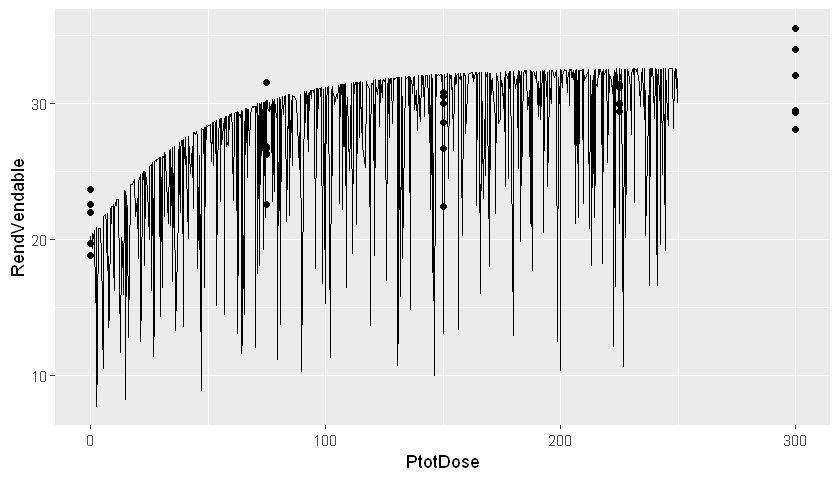

In [21]:
options(repr.plot.wight = 4, repr.plot.height = 4)
df_mm %>%
  filter(NoEssai == r_sample$NoEssai) %>%
  ggplot(aes(x = PtotDose, y = RendVendable)) +
  geom_point() +
  geom_line(aes(x = PtotDose, y = Prediction), data = reference_stack) # a P trial

### Prediction specific to trial type

Reference trial where only __N__ dose varied: `(test_type = N)`

In [22]:
test_types <- read.csv('output/test_types.csv')
reference_row <- df_mm %>%
  filter(ID == test_types$ID[1])

In [23]:
test_types

X,NoEssai,test_type,ID
<int>,<int>,<fct>,<fct>
1745,8804,N,8804-5-5
5524,412,P,412-3-4
3843,320,K,320-3-3


In [24]:
n_grid_samples <- 251 # number of samples
N_range <- c(0, 250)
P_range <- c(reference_row$PtotDose, reference_row$PtotDose)
K_range <- c(reference_row$KtotDose, reference_row$KtotDose)

In [25]:
reference_stack <- data.frame(matrix(nrow = n_grid_samples, ncol = ncol(reference_row)))
colnames(reference_stack) <- colnames(reference_row)
for (i in 1:ncol(reference_stack)) {
  reference_stack[, i] = reference_row[1, i]
}
set.seed(936492)
reference_stack$NtotDose <- runif(n_grid_samples, N_range[1], N_range[2])
reference_stack$PtotDose <- runif(n_grid_samples, P_range[1], P_range[2])
reference_stack$KtotDose <- runif(n_grid_samples, K_range[1], K_range[2])

The prediction

In [26]:
reference_stack <- reference_stack %>%
    mutate(Prediction = pred_mitsch(mm = mm_NPK, newdata = ., rhs = rhs)$pred,
           cost = NtotDose * N_cost + PtotDose * P_cost + KtotDose * K_cost, 
           revenue = Prediction * price_yield, 
           benefit = revenue - cost)

The optimum

In [27]:
reference_stack[which.max(reference_stack$benefit), c(dose_vars, 'Prediction', 'benefit')]

,NtotDose,PtotDose,KtotDose,Prediction,benefit
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
143,248.4125,120.0013,120.007,35.67834,8381.483


In [28]:
# Save predictions for N trial
write_csv(reference_stack[, c(dose_vars, 'Prediction', 'benefit')], 'output/yield_mitsch_N.csv')

Plot for the N trial

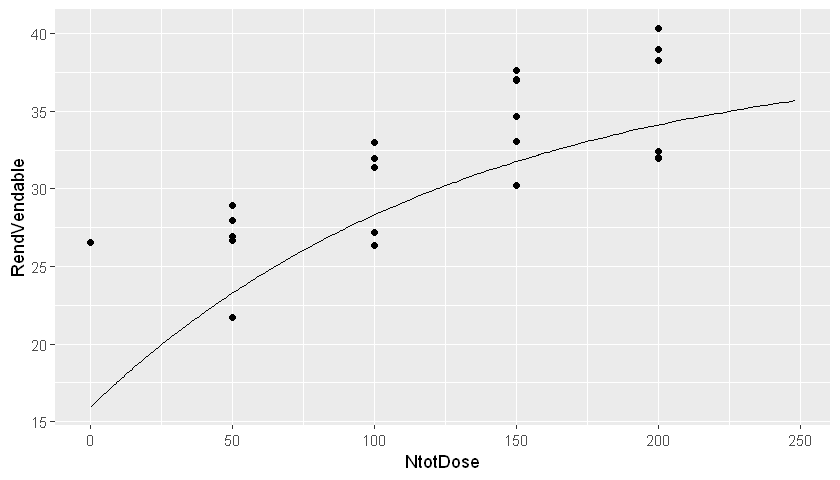

In [29]:
options(repr.plot.wigth = 4, repr.plot.height = 4)
df_mm %>%
    filter(NoEssai == reference_row$NoEssai) %>% 
    ggplot(aes(x = NtotDose, y = RendVendable)) +
    geom_point() +
    geom_line(aes(x = NtotDose, y = Prediction), data = reference_stack)

Reference trial where only __P__ dose varied: `(test_type = P)`

In [30]:
reference_row <- df_mm %>%
  filter(ID == test_types$ID[2])

In [31]:
n_grid_samples <- 251 # number of samples
N_range <- c(reference_row$NtotDose, reference_row$NtotDose)
P_range <- c(0, 250)
K_range <- c(reference_row$KtotDose, reference_row$KtotDose)

In [32]:
reference_stack <- data.frame(matrix(nrow = n_grid_samples, ncol = ncol(reference_row)))
colnames(reference_stack) <- colnames(reference_row)
for (i in 1:ncol(reference_stack)) {
  reference_stack[, i] = reference_row[1, i]
}
set.seed(936492)
reference_stack$NtotDose <- runif(n_grid_samples, N_range[1], N_range[2])
reference_stack$PtotDose <- runif(n_grid_samples, P_range[1], P_range[2])
reference_stack$KtotDose <- runif(n_grid_samples, K_range[1], K_range[2])

The prediction

In [33]:
reference_stack <- reference_stack %>%
    mutate(Prediction = pred_mitsch(mm = mm_NPK, newdata = ., rhs = rhs)$pred,
           cost = NtotDose * N_cost + PtotDose * P_cost + KtotDose * K_cost, 
           revenue = Prediction * price_yield, 
           benefit = revenue - cost,
           P = PtotDose*0.436)

The optimum

In [34]:
reference_stack[which.max(reference_stack$benefit), c(dose_vars, 'Prediction', 'benefit', 'P')]

,NtotDose,PtotDose,KtotDose,Prediction,benefit,P
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
36,164.9965,88.19127,214.9956,32.1963,7560.574,38.45139


In [35]:
# Save predictions for P trial
write_csv(reference_stack[, c(dose_vars, 'Prediction', 'benefit', 'P')], 'output/yield_mitsch_P.csv')

Plot for the P trial

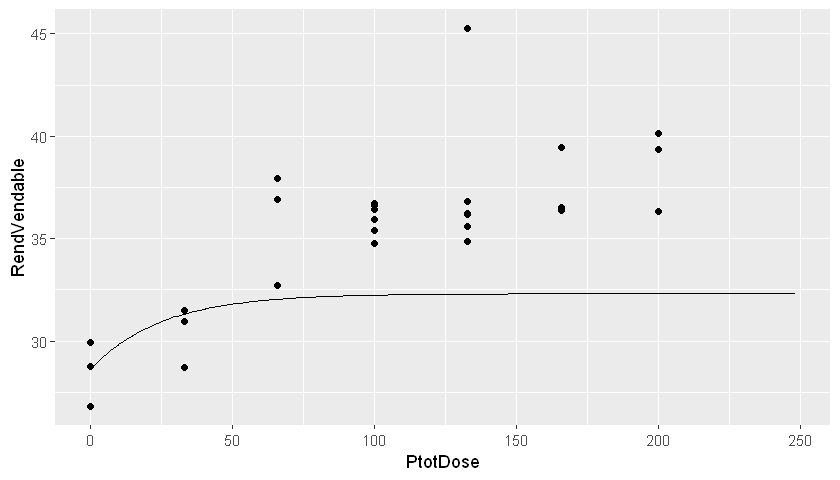

In [36]:
df_mm %>%
    filter(NoEssai == reference_row$NoEssai) %>% 
    ggplot(aes(x = PtotDose, y = RendVendable)) +
    geom_point() +
    geom_line(aes(x = PtotDose, y = Prediction), data = reference_stack)

Reference trial where only __K__ dose varied: `(test_type = K)`

In [37]:
reference_row <- df_mm %>%
  filter(ID == test_types$ID[3])

In [38]:
n_grid_samples <- 251 # number of samples
N_range <- c(reference_row$NtotDose, reference_row$NtotDose)
P_range <- c(reference_row$PtotDose, reference_row$PtotDose)
K_range <- c(0, 250)

In [39]:
reference_stack <- data.frame(matrix(nrow = n_grid_samples, ncol = ncol(reference_row)))
colnames(reference_stack) <- colnames(reference_row)
for (i in 1:ncol(reference_stack)) {
  reference_stack[, i] = reference_row[1, i]
}
set.seed(936492)
reference_stack$NtotDose <- runif(n_grid_samples, N_range[1], N_range[2])
reference_stack$PtotDose <- runif(n_grid_samples, P_range[1], P_range[2])
reference_stack$KtotDose <- runif(n_grid_samples, K_range[1], K_range[2])

The prediction

In [40]:
reference_stack <- reference_stack %>%
    mutate(Prediction = pred_mitsch(mm = mm_NPK, newdata = ., rhs = rhs)$pred,
           cost = NtotDose * N_cost + PtotDose * P_cost + KtotDose * K_cost, 
           revenue = Prediction * price_yield, 
           benefit = revenue - cost,
           K = KtotDose*0.830)

The optimum

In [41]:
reference_stack[which.max(reference_stack$benefit), c(dose_vars, 'Prediction', 'benefit', 'K')]

,NtotDose,PtotDose,KtotDose,Prediction,benefit,K
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
240,149.9983,50.00981,0.3544926,33.4415,8125.047,0.2942288


In [42]:
# Save predictions for K trial
write_csv(reference_stack[, c(dose_vars, 'Prediction', 'benefit', 'K')], 'output/yield_mitsch_K.csv')

Plot for the K trial

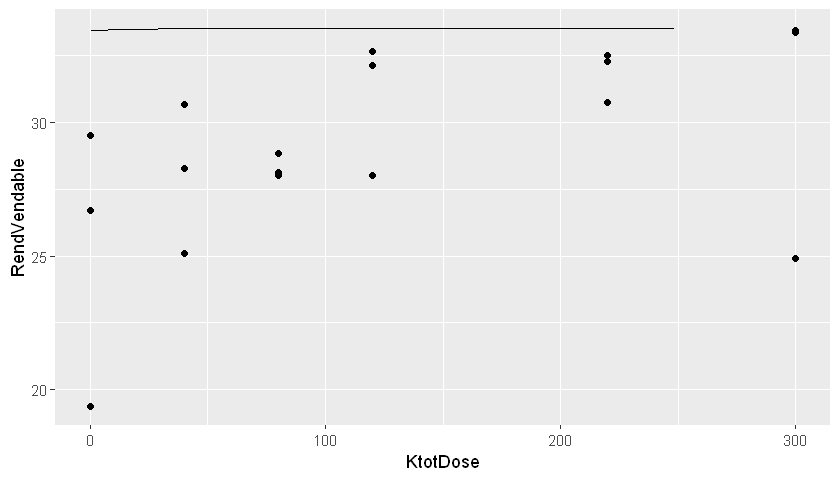

In [43]:
df_mm %>%
    filter(NoEssai == reference_row$NoEssai) %>% 
    ggplot(aes(x = KtotDose, y = RendVendable)) +
    geom_point() +
    geom_line(aes(x = KtotDose, y = Prediction), data = reference_stack)